# 客户价值分析

## 前言

### RFM简介

* RFM是一种用户客户价值分析的方法，通常用于数据库营销和直接营销，在众多的客户关系管理(CRM)的分析模式中，RFM模型是被广泛提到的。
* RFM模型的三个维度：
    - Recency 最近一次消费
    - Frequency 消费频率
    - Monetary 消费金额
* 基于RFM模型的三个维度，可以将客户分群，衡量客户价值和客户创利能力，对不同的客户群体开展不同的个性化服务，将有限的资源合理地分配给不同价值的客户，实现效益最大化。

### 数据集

* 本次实例所用数据由 Machine Learning Repository 基于一个英国电商公司从2010年12月1号到2011年12月9号的真实的交易数据集进行脱敏处理的。 该电商主要销售的商品是各类礼品。数据下载地址：

    https://archive.ics.uci.edu/ml/datasets/Online+Retail
* 数据集大小：(541909,8)
* 数据指标说明
    - InvoiceNo：发票号码，类型数据，每个事务即每笔交易都拥有唯一一个6位整数数字的号码。如果这个号码是以字母C开头，意味着这笔交易是取消的。
    - StockCode：产品（类目）编码，类型数据，每个不同的产品都拥有唯一的一个5位整数数字号码。
    - Description：产品（类目）名称，类型数据。
    - Quantity：在每个发生事务中，即每笔交易中每个产品（类目）的数量，数值数据。
    - InvoiceDate：发票日期和时间，数值数据，每条事务产生的具体日期和时间。
    - UnitPrice：商品单价，数值数据，产品单价/英镑。
    - CustomerID：客户ID，类型数据，每个客户都有唯一一个5位数字的整数号码。
    - Country：国家名称，类型数据，代表每个客户所在的国家或者地区名称。

### 实例目的

* 本实例基于电商分销数据，希望借助KMeans算法对客户进行分群，并应用RFM模型对细分后的客户群体进行解读，识别出高价值客户。
* 在本实例中，主要希望实现以下三个目标：
    1. 基于电商分销数据，对客户进行群体分类
    2. 特定客户群体特定分析，比较各群体的差异及价值
    3. 对不同价值的客户群体制定对应的运营策略

## 实例分析

In [1]:
#导入必要的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
print('import success!')

import success!


In [2]:
sns.set(font='kaiti',rc={'axes.unicode_minus' : False}) #解决中文和负号显示问题

### 数据加载

In [3]:
retail_df = pd.read_excel('Online Retail.xlsx')
retail_df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 数据探索

In [4]:
retail_df.describe(include='all')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,541909.0,541909,540455,541909.000000,541909,541909.000000,406829.000000,541909
unique,25900.0,4070,4223,NaN,23260,NaN,NaN,38
top,573585.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-10-31 14:41:00,NaN,NaN,United Kingdom
freq,1114.0,2313,2369,NaN,1114,NaN,NaN,495478
first,NaN,NaN,NaN,NaN,2010-12-01 08:26:00,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-12-09 12:50:00,NaN,NaN,NaN
mean,NaN,NaN,NaN,9.552250,NaN,4.611114,15287.690570,NaN
std,NaN,NaN,NaN,218.081158,NaN,96.759853,1713.600303,NaN
min,NaN,NaN,NaN,-80995.000000,NaN,-11062.060000,12346.000000,NaN
25%,NaN,NaN,NaN,1.000000,NaN,1.250000,13953.000000,NaN


* 数据集共541909行，8个字段，Description\CustomerID存在空值，后续分析需要涉及客户分群，所以对于CustomerID空的记录需要删除
* Quantity、UnitPrice字段最小值都是负值（并且Quantity最大最小值刚好互为相反数），可能情况是对应的订单发生了退货，也可能是数据本身存在问题，在后续的分析中考虑删除
* Quantity、UnitPrice字段均值都接近75%分位数，说明受到了极大值影响
* Country字段United Kingdom是最高频率，该电商约九成的客户来源英国本土，其他客户来自37个国家或地区，即该电商主打本土客户

In [5]:
retail_df[retail_df['Quantity'].isin([-80995.0,80995.0])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,2011-12-09 09:27:00,2.08,16446.0,United Kingdom


* 可以看出最大数量的交易是因为重复下单，而取消了第二个订单

### 数据清洗

#### 删除重复数据 

* 一次交易，订单中可能会有多个商品，所以一个InvoiceNo可能会对应多个StockCode、Description

In [6]:
#查看重复数据
retail_df[retail_df.duplicated(keep=False)].sort_values(by='InvoiceDate').head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
485,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
489,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
494,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,2010-12-01 11:45:00,1.25,17908.0,United Kingdom
521,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,2010-12-01 11:45:00,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,2010-12-01 11:45:00,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,2010-12-01 11:45:00,4.95,17908.0,United Kingdom
604,536412,21448,12 DAISY PEGS IN WOOD BOX,2,2010-12-01 11:49:00,1.65,17920.0,United Kingdom
605,536412,22902,TOTE BAG I LOVE LONDON,7,2010-12-01 11:49:00,2.10,17920.0,United Kingdom


In [7]:
#删除重复数据，保留第一条
retail_df.drop_duplicates(inplace=True)
retail_df.duplicated().any() #输出False表示没有重复数据

False

#### 删除空值

In [8]:
retail_df.dropna(inplace=True)
retail_df.isna().any().any() #若返回False，表示不存在任何空值

False

#### 删除"撤销"订单

In [9]:
raw_df = retail_df[~retail_df['Quantity'] < 0] #被撤销的订单Quantity字段值小于0
raw_df.describe()

,Quantity,UnitPrice,CustomerID
count,392732.000000,392732.000000,392732.000000
mean,13.153718,3.125596,15287.734822
std,181.588420,22.240725,1713.567773
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13955.000000
50%,6.000000,1.950000,15150.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,8142.750000,18287.000000


* UnitPrice 单价为0的商品，不知道也没得问，就假设是一些免费小礼物（刷销量？）

In [10]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      392732 non-null object
StockCode      392732 non-null object
Description    392732 non-null object
Quantity       392732 non-null int64
InvoiceDate    392732 non-null datetime64[ns]
UnitPrice      392732 non-null float64
CustomerID     392732 non-null float64
Country        392732 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.0+ MB


* 用于后续分析的数据共计39万条

### 描述性分析

#### 月份维度

* 以下的分析主要基于月份维度，对数据进行描述性统计分析，因此先构造用于分析的"月份"维度数据
* 数据是从2010-12-01至2011-12-09，按月份分析，添加辅助列，数据格式为2010-12

In [11]:
#查看时间数据格式
raw_df.iloc[0]['InvoiceDate']

Timestamp('2010-12-01 08:26:00')

In [12]:
#添加辅助列InvoiceMonth
raw_df['InvoiceMonth'] = raw_df['InvoiceDate'].apply(lambda x : x.strftime('%Y-%m'))
raw_df.head(2)

C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12


In [13]:
#添加辅助列 Price，代表该产品的总消费金额
raw_df['Price'] = raw_df['Quantity'] * raw_df['UnitPrice']
raw_df.head(2)

C:\Software\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,Price
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


##### 每月客户购买趋势

In [14]:
#数据1 每月消费客户数（非订单数目，一个客户可能会有多个订单）
month_customers_df = raw_df[['CustomerID','InvoiceMonth']].drop_duplicates().groupby('InvoiceMonth').count() 
month_lst = list(month_customers_df.index) #月份数据列表
month_customers_lst = list(month_customers_df['CustomerID'].values) #每月消费客户数列表
#数据2 每月消费总金额
month_price_df = raw_df[['Price','InvoiceMonth']].groupby('InvoiceMonth').sum()
month_price_lst = list(month_price_df['Price'].values) #每月消费金额列表
#数据3 每月人均消费金额
month_customers_avg_price_lst = list(np.array(month_price_lst) / np.array(month_customers_lst)) #每月人均消费金额列表

In [15]:
#利用pyecharts作图，需要将数据格式由np.float64转换为Python原生的float/int
for i in range(13):
    month_customers_lst[i] = int(month_customers_lst[i])
    month_price_lst[i] = round(float(month_price_lst[i]),ndigits=1)
    month_customers_avg_price_lst[i] = round(float(month_customers_avg_price_lst[i]),ndigits=1)

In [16]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392732 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo       392732 non-null object
StockCode       392732 non-null object
Description     392732 non-null object
Quantity        392732 non-null int64
InvoiceDate     392732 non-null datetime64[ns]
UnitPrice       392732 non-null float64
CustomerID      392732 non-null float64
Country         392732 non-null object
InvoiceMonth    392732 non-null object
Price           392732 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 33.0+ MB


In [17]:
from pyecharts.charts import Bar,Line
from pyecharts import options as opts
from pyecharts.globals import ThemeType

In [18]:
bar_1 = (
    Bar(init_opts=opts.InitOpts(theme=ThemeType.SHINE))
    .add_xaxis(month_lst)
    .add_yaxis('每月消费客户数', month_customers_lst,gap='5%',yaxis_index=0)
    .add_yaxis('每月消费总金额', month_price_lst,gap='5%', yaxis_index=1)
    .extend_axis(
            yaxis=opts.AxisOpts(
                axislabel_opts=opts.LabelOpts(formatter="{value}")
            )
        )
    .set_series_opts(label_opts=opts.LabelOpts(is_show=False, font_size=12),
                     #添加标记线/点
                    markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="average", name="平均值")])
                    )
    #全局配置项
    .set_global_opts(
                #标题 子标题
                title_opts=opts.TitleOpts(title="每月客户消费趋势", subtitle="按月份"),
                #图例位置
                legend_opts=opts.LegendOpts(pos_left='30%'),
                #y轴标签显示格式
                yaxis_opts=opts.AxisOpts(axislabel_opts=opts.LabelOpts(formatter="{value}")),
                #显示工具箱，竖向,位置最右侧
                toolbox_opts=opts.ToolboxOpts(orient='vertical',pos_left='right'),
                #设置滑动窗口起始和终止
                datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
                    )
)
    
line_1 = (
    Line(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
    .add_xaxis(month_lst)
    .add_yaxis('每月人均消费金额', month_customers_avg_price_lst,yaxis_index=0)
    .set_series_opts(label_opts=opts.LabelOpts(is_show=True, font_size=12),
                     markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max", name="最大值")]),
                    )
#     .set_global_opts(title_opts=opts.TitleOpts(title="一线城市数据分析职位薪资概况", subtitle="按所在城市"),
#                     toolbox_opts=opts.ToolboxOpts())
)
bar_1.overlap(line_1)
bar_1.render_notebook()

* 2011-09至2011-11三个月的消费客户数和消费总金额稳步上涨，达到最高点，但是人均消费金额是2011-12和2011-01这两个月份较高

In [203]:
raw_df[raw_df['InvoiceMonth'].isin(['2011-01', '2011-12'])][['InvoiceNo','CustomerID','Quantity','InvoiceMonth','Price']].sort_values(by='Quantity',ascending=False).head(5)

,InvoiceNo,CustomerID,Quantity,InvoiceMonth,Price
540421,581483,16446.0,80995,2011-12,168469.6
61619,541431,12346.0,74215,2011-01,77183.6
52711,540815,15749.0,3114,2011-01,6539.4
52710,540815,15749.0,2000,2011-01,3700.0
52709,540815,15749.0,1930,2011-01,4921.5


* 可以印证，2011-12和2011-01这两个月份在消费人数不高的情况下，人均消费金额却很高，原因是两个"超级"大单的存在，抬高了平均水平

##### 每月订单趋势

In [20]:
#数据1 每月订单数目 注意不是每月记录数 InvoiceNo是可以重复的
month_order_df = raw_df[['InvoiceNo','InvoiceMonth']].drop_duplicates().groupby('InvoiceMonth').count()
month_order_lst = [] #每月订单数目列表
for month in month_lst:
    month_order_lst.append(int(month_order_df.loc[month,'InvoiceNo']))
#数据2 每月产品采购量
month_quantity_df = raw_df[['Quantity','InvoiceMonth']].groupby('InvoiceMonth').sum()
month_quantity_lst = [] #每月产品采购量
for month in month_lst:
    month_quantity_lst.append(int(month_quantity_df.loc[month,'Quantity']))

In [21]:
from pyecharts.charts import EffectScatter
from pyecharts.globals import SymbolType

In [22]:
effectScatter_1 = (
        EffectScatter(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
        #x轴标签
        .add_xaxis(month_lst)
        #y轴数据
        .add_yaxis(
            "每月订单数目", month_order_lst, symbol=SymbolType.DIAMOND, yaxis_index=0
            )
        .add_yaxis(
            "每月产品销量",month_quantity_lst,symbol=SymbolType.ARROW, yaxis_index=1
            )
        .extend_axis(yaxis=opts.AxisOpts())
        .set_series_opts(label_opts=opts.LabelOpts(is_show=True, font_size=12),
                     #添加标记线/点
#                     markline_opts=opts.MarkLineOpts(data=[opts.MarkLineItem(type_="min", name="平均值")]),
#                     markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_='max',name='最大值'),
#                                                             opts.MarkPointItem(type_='min',name='最小值')]),
                    )
        .set_global_opts(
            title_opts=opts.TitleOpts(title="每月产品销售趋势"),
            #图例位置
#             legend_opts=opts.LegendOpts(pos_left='30%'),
            #y轴标签显示格式
            yaxis_opts=opts.AxisOpts(name='订单数目',axislabel_opts=opts.LabelOpts(formatter="{value}")),
            #显示工具箱，竖向,位置最右侧
            toolbox_opts=opts.ToolboxOpts(orient='vertical',pos_left='right'),
            #设置滑动窗口起始和终止
#             datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
            
        )
)
effectScatter_1.render_notebook()

* 订单和销量趋势和之前的客户消费趋势基本吻合，订单数和产品销量之间距离越大，则均单销量越高，可以看出2011-01、2011-12的均单销量是前一前二，也是因为之前分析过的超级大单的因素，均单销量位于三四的是2011-08和2011-09

#### 客户维度

* 探索一下客户购买产品的喜好，看下客户对哪个价格区间的商品情有独钟

In [23]:
#查看产品单价
unique_unitprice_lst = list(raw_df['UnitPrice'].unique())
len(unique_unitprice_lst) #共计441个单价 其中100以上的价格只有73个
unique_unitprice_lst.sort(reverse=True) #按降序排列

* 因为价格区间跨度非常大，想要把每个价格区间的客户购买数都展现出来不太可能，除非很粗粒度的进行划分，但是这样选择结果很有可能会导致小价格区间的购买数非常高，并不能实际看出客户对于价格区间的喜好，所以考虑以80%的购买数为界，考虑到哪个价格为止的商品销量达到了总销量的80%

In [24]:
# raw_df['Quantity'].sum() #5165886
i = 0
while (raw_df[raw_df['Quantity'] <= i]['Quantity'].sum() / 5165886) <= 0.80:
    i += 5
print('===价格{}及以下的商品销量达到了总销量的80%==='.format(i))

===价格195及以下的商品销量达到了总销量的80%===


In [25]:
unitPrice_quantity_lst = []
#划分价格区间，以5为间隔，左闭右开 [0,5) [5,10)
for i in np.linspace(5,195,39):
    unitPrice_quantity_lst.append(int(raw_df[raw_df['UnitPrice'] < i]['Quantity'].sum()))
len( unitPrice_quantity_lst)

39

In [26]:
#归一化
unitPrice_quantity_lst_max = max(unitPrice_quantity_lst)
unitPrice_quantity_lst_min = min(unitPrice_quantity_lst)
for i in range(39):
    unitPrice_quantity_lst[i] = (unitPrice_quantity_lst[i] - unitPrice_quantity_lst_min) / (unitPrice_quantity_lst_max - unitPrice_quantity_lst_min)

In [27]:
bar_2 = (
        Bar(init_opts=opts.InitOpts(theme=ThemeType.LIGHT))
        .add_xaxis(list(np.linspace(5,195,39)))
        .add_yaxis("客户购买数量", unitPrice_quantity_lst, category_gap=0,
                  )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                  )
        .set_global_opts(title_opts=opts.TitleOpts(title="客户购买偏好"),
                #图例位置
                legend_opts=opts.LegendOpts(pos_left='30%'),
                #y轴标签显示格式
                yaxis_opts=opts.AxisOpts(min_=0.95),
                #显示工具箱，竖向,位置最右侧
                toolbox_opts=opts.ToolboxOpts(orient='vertical',pos_left='right'),
                #设置滑动窗口起始和终止
                datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
                        )
    )
bar_2.render_notebook()

* 从上图看出，客户对于价格55以上的产品购买欲几乎无差别，无差异扫货；而对于价格50以下的产品购买欲稍稍差一点

##### 客户分层

* 自定义new新客户、active活跃客户、unactive不活跃客户、back回流客户，对客户进行分层
* 一开始客户都属于未消费客户
    - 本月有消费
        - 上月new --> active
        - 上月active --> active
        - 上月unactive --> back
        - 上月未消费 --> new
    - 本月未消费
        - 上月new --> unactive
        - 上月active --> unactive
        - 上月unactive --> unactive
        - 上月未消费 --> 未消费

In [28]:
#利用数据透视表展示客户每个月消费行为
raw_customer_status_df = raw_df.pivot_table(index='CustomerID',columns='InvoiceMonth',
                                            values='InvoiceDate',aggfunc='count',fill_value=-1) 
                                            #统计的是每个月客户购买的产品种类数,对于客户类型分析无伤大雅，所有空值填充为-1
raw_customer_status_df.head(3)

InvoiceMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12346.0,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
12347.0,31,29,-1,-1,24,-1,18,-1,22,-1,47,-1,11
12348.0,17,6,-1,-1,5,-1,-1,-1,-1,3,-1,-1,-1


In [29]:
#自定义函数，将客户每月类型进行定义
def get_customer_level(series):
    #客户类型
    customer_level = []
    for i in range(13):
        #本月有消费
        if series[i] != -1:
            #如果是第一个月
            if i == 0:
                customer_level.append('new')
            else:
#                 print(customer_level)
#                 print('===={}===='.format(i))
#                 print(series[i-1])
                #之前是没有消费过的状态
                if customer_level[i-1] == 'nop':
                    customer_level.append('new')
                #上月未消费
                elif customer_level[i-1] == 'unactive':
                    customer_level.append('back')
                #上月消费了
                else:
                    customer_level.append('active')
        #本月未消费
        else:
            #如果是第一个月
            if i == 0:
                customer_level.append('nop')
            else:
                #之前是没有消费过的状态
                if customer_level[i-1] == 'nop':
                    customer_level.append('nop')
                #上月其他状态
                else:
                    customer_level.append('unactive')
    return pd.Series(customer_level,index=month_lst)

In [30]:
customer_level_df = raw_customer_status_df.apply(get_customer_level,axis=1) #指定轴方向
customer_level_df.head(3)

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12346.0,nop,new,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive,unactive
12347.0,new,active,unactive,unactive,back,unactive,back,unactive,back,unactive,back,unactive,back
12348.0,new,active,unactive,unactive,back,unactive,unactive,unactive,unactive,back,unactive,unactive,unactive


In [31]:
#现在计算每个月各个类型客户的数目，先将没有消费过状态nop替换为np.nan,按列应用value_counts
customer_level_counts_df = customer_level_df.replace('nop',np.nan).apply(lambda x : x.value_counts())
customer_level_counts_df

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
active,NaN,324.0,262,290,304,368,410,365,388,425,489,622,371
back,NaN,NaN,116,232,252,404,339,396,378,542,517,719,203
new,885.0,417.0,380,452,300,284,242,188,169,299,358,324,41
unactive,NaN,561.0,924,1160,1578,1662,1969,2199,2382,2350,2610,2633,3724


In [32]:
customer_level_dict = {}
for index in ['active','back','new','unactive']:
    count_lst = []
    for value in customer_level_counts_df.fillna(0).loc[index]:
        if value == 0:
            count_lst.append(np.nan)
        else:
            count_lst.append(int(value))
    customer_level_dict[index] = count_lst
customer_level_dict

{'active': [nan, 324, 262, 290, 304, 368, 410, 365, 388, 425, 489, 622, 371],
 'back': [nan, nan, 116, 232, 252, 404, 339, 396, 378, 542, 517, 719, 203],
 'new': [885, 417, 380, 452, 300, 284, 242, 188, 169, 299, 358, 324, 41],
 'unactive': [nan,
  561,
  924,
  1160,
  1578,
  1662,
  1969,
  2199,
  2382,
  2350,
  2610,
  2633,
  3724]}

In [33]:
line_2 = (
        Line(init_opts=opts.InitOpts(theme=ThemeType.INFOGRAPHIC))
        .add_xaxis(month_lst)
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                  )
        .set_global_opts(title_opts=opts.TitleOpts(title="客户分层"),
                #图例位置
                legend_opts=opts.LegendOpts(pos_left='30%'),
                #y轴标签显示格式
#                 yaxis_opts=opts.AxisOpts(min_=0.95),
                #显示工具箱，竖向,位置最右侧
                toolbox_opts=opts.ToolboxOpts(orient='vertical',pos_left='right'),
                #设置滑动窗口起始和终止
#                 datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
                 #是否紧贴y轴
#                  xaxis_opts=opts.AxisOpts(
#                 axistick_opts=opts.AxisTickOpts(is_align_with_label=True),
#                 is_scale=False,
#                 boundary_gap=False,
#             ),
                        )
    )
for customer_level in ['active','back','new','unactive']:
    line_2.add_yaxis(customer_level, customer_level_dict[customer_level],
                     #连线是否平滑
                     is_smooth=True,
                     #连线是否成阶梯
#                      is_step=True,
                     areastyle_opts=opts.AreaStyleOpts(opacity=0.6))
line_2.render_notebook()

* 从上图可以看出，该电商客户总体粘性不强，随着时间增长每个月都在流失一定量客户 --> 不活跃客户（除了2011-09），需要制定相关策略激活（挽回）这部分潜在市场
* 每月新增客户数整体呈现下降趋势，说明拓展力度不够，直到211-09至2011-11期间新增客户、回头客户、活跃客户数量有所起色

##### 客户复购率、客户回购率

* 复购率在本实例中如下定义：每个月内，购买商品次数超过1次的客户占比，严格来说，统计口径是，每个月内订单数超过1个的客户占比
* 回购率定义：上一个月未购买客户，本月有购买记录的客户占比
    - 本月有消费
        - 上月有消费 --> 回购 1
        - 上月无消费 --> 0
    - 本月无消费 --> np.nan

In [34]:
#客户每月订单数目统计（非客户记录数，一个订单可以包含多款产品，即多条记录），本月没有订单则赋值-1
customer_purchase_df = raw_df[['CustomerID','InvoiceMonth','InvoiceNo',]].drop_duplicates().pivot_table(
                                            index='CustomerID',columns='InvoiceMonth',
                                            values='InvoiceNo',aggfunc='count',fill_value=-1)
customer_purchase_df.head(3)

InvoiceMonth,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12346.0,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
12347.0,1,1,-1,-1,1,-1,1,-1,1,-1,1,-1,1
12348.0,1,1,-1,-1,1,-1,-1,-1,-1,1,-1,-1,-1


In [35]:
#数据1 复购客户率
again_customers_rate = []
for index in month_lst:
    #本月订单数大于1的客户数 --> 复购客户数
    again_customers = sum(customer_purchase_df[index] > 1)
    #本月订单数等于1的客户数 --> 有消费客户数
    purchase_customers = sum(customer_purchase_df[index] == 1)
    #计算复购率
    again_customers_rate.append(
                                round(float(again_customers / (again_customers + purchase_customers)),ndigits=3)
    )
again_customers_rate    

[0.297,
 0.201,
 0.198,
 0.206,
 0.196,
 0.264,
 0.221,
 0.239,
 0.21,
 0.214,
 0.237,
 0.324,
 0.172]

In [36]:
#构造客户回购记录数据
def get_customer_back(in_data):
    '''
    传入参数：某个客户每月订单数目 Series
    输出：客户回购记录，某月回购记为1，否则有消费记为0，无消费记为np.nan
    初始2010-12均为np.nan，因为无之前的数据，所以第一个月都不是回购客户
    判定规则
    - 本月有消费
        - 上月有消费 --> 回购 1
        - 上月无消费 --> 0
    - 本月无消费 --> np.nan
    '''
    #回购信息列表
    back_lst = [np.nan,]
    for i in range(1,13,1):
        #本月有消费
        if in_data[i] >= 1:
            if in_data[i - 1] == 1 or in_data[i - 1] == 0:
                back_lst.append(1)
            else:
                back_lst.append(0)
        #本月无消费
        else:
            back_lst.append(np.nan)
    return pd.Series(back_lst,index=month_lst)

In [37]:
back_customers_df = customer_purchase_df.apply(get_customer_back,axis=1)
back_customers_df.head(3)

,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12
CustomerID,,,,,,,,,,,,,
12346.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,1.0,NaN,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0
12348.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [38]:
#数据2 回购客户率
back_customers_rate = [np.nan,]
for index in month_lst[1:]:
    back_customers_rate.append(
                            #回购客户数 / 有消费客户数
                            round(float(back_customers_df[index].sum() / back_customers_df[index].count()),ndigits=3)
    )
back_customers_rate

[nan,
 0.24,
 0.232,
 0.199,
 0.217,
 0.239,
 0.243,
 0.242,
 0.263,
 0.227,
 0.243,
 0.235,
 0.285]

In [39]:
line_3 = (
        Line(init_opts=opts.InitOpts())
        .add_xaxis(month_lst)
        .add_yaxis(
            "复购率",
            again_customers_rate,
            #点的样式
            symbol="triangle",
            #样式大小
            symbol_size=15,
            #连线样式 颜色 宽度 实线虚线点线
            linestyle_opts=opts.LineStyleOpts(color="green", width=2, type_="dashed"),
            #标签
            label_opts=opts.LabelOpts(is_show=False),
            #元素风格
            itemstyle_opts=opts.ItemStyleOpts(
                border_width=3, border_color="yellow", color="blue"
            ),
        )
        .add_yaxis(
            "回购率",
            back_customers_rate,
            symbol="diamond",
            symbol_size=20,
            linestyle_opts=opts.LineStyleOpts(color="red", width=3, type_="dotted"),
            label_opts=opts.LabelOpts(is_show=False),
            itemstyle_opts=opts.ItemStyleOpts(
                border_width=3, border_color="white", color="orange"
            ),
        )
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False),
                 #添加标记线/点
                markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_='max',name='最大值'),
                                                        opts.MarkPointItem(type_='min',name='最小值')]),
                    )
        .set_global_opts(
            title_opts=opts.TitleOpts(title="客户复购率回购率",subtitle='按月统计'),
            xaxis_opts=opts.AxisOpts(type_="category"),
            yaxis_opts=opts.AxisOpts(
                type_="value",
                axistick_opts=opts.AxisTickOpts(is_show=True),
                #是否显示分割线
                splitline_opts=opts.SplitLineOpts(is_show=True),
                #y轴标签最小值
                min_=0.15
            ),
            tooltip_opts=opts.TooltipOpts(is_show=True),
            #图例位置
            legend_opts=opts.LegendOpts(pos_left='30%'),
            #显示工具箱，竖向,位置最右侧
            toolbox_opts=opts.ToolboxOpts(orient='vertical',pos_left='right'),
            #设置滑动窗口起始和终止
#             datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
        )
    )
line_3.render_notebook()

* 客户复购率和回购率基本上都稳定在20%至30%，普遍不高，存在上涨空间，并且二者变化趋势基本一致
* 复购率和回购率都集中在年末2011-11和2011-12达到最大值

### 聚类分析

* 下面利用RFM模型及KMeans聚类算法对客户进行分群，探求各个群体客户特征及识别高价值客户

##### 指标构造

In [72]:
#构建RFM模型的三个指标数据
'''
R -- 最近一次购买日期距 2011-12-10 的天数
F -- 观测期内订单数目
M -- 观测期内消费总金额
'''
import datetime
#指定截止日期是2011-12-10
end_day =datetime.datetime(2011,12,10)
#计算RFM值,分别应用不同的聚合函数
rfm_df = raw_df.groupby('CustomerID').agg({'InvoiceDate' : (lambda x:(end_day - x.max()).days), #R
                                           'InvoiceNo' : (lambda x:len(x.unique())), #F
                                           'Price' : np.sum}) #M
rfm_df.rename(columns={'InvoiceDate' : 'Recency','InvoiceNo' : 'Frequency','Price' : 'Monetary'},inplace=True)
rfm_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,18,1,1757.55
12350.0,310,1,334.40


In [74]:
rfm_df.sort_values(by='Monetary',ascending=False).head(2)

,Recency,Frequency,Monetary
CustomerID,,,
14646.0,1,74,280206.02
18102.0,0,60,259657.30


In [76]:
rfm_df.describe()

,Recency,Frequency,Monetary
count,4339.000000,4339.000000,4339.000000
mean,92.041484,4.271952,2048.215924
std,100.007757,7.705493,8984.248352
min,0.000000,1.000000,0.000000
25%,17.000000,1.000000,306.455000
50%,50.000000,2.000000,668.560000
75%,141.500000,5.000000,1660.315000
max,373.000000,210.000000,280206.020000


##### 特征工程

* 为消除量纲的影响，对特征数据进行标准化，标准化的方法有最大最小值标准化，标准差标准化，log函数标准化等，本实例采用最常用的标准差标准化方法

In [77]:
from sklearn.preprocessing import StandardScaler #导入标准化方法

In [78]:
#标准化数据
stand_scaler = StandardScaler() 
train_data = stand_scaler.fit_transform(rfm_df)
train_data

C:\Software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Software\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


array([[ 2.32967293e+00, -4.24674873e-01,  8.36397668e+00],
       [-9.00448767e-01,  3.54080191e-01,  2.51778965e-01],
       [-1.70421263e-01, -3.52973410e-02, -2.79383250e-02],
       ...,
       [-8.50446884e-01, -2.94882363e-01, -2.08184524e-01],
       [-8.90448391e-01,  1.52221279e+00, -2.98993684e-04],
       [-5.00433697e-01, -1.65089852e-01, -2.34811224e-02]])

##### 模型训练

In [79]:
from sklearn.cluster import KMeans #导入聚类算法

* KMeans聚类算法中，k值是可以自己设定的，但是k值的选取对于聚类效果是有影响的，一般对K值的确定可以采用手肘法和轮廓系数方法，在本实例中采用手肘法

In [80]:
#确定合适的K的取值
#手肘法的评价参数是SSE 误差平方和
cluster_errors = []
for cluster_num in range(2,8):
    kmeans = KMeans(n_clusters=cluster_num,n_init=20,n_jobs=2,random_state=2)
    #模型训练
    kmeans.fit(train_data)
    #模型误差
    #Sum of squared distances of samples to their closest cluster center.
    cluster_errors.append(kmeans.inertia_)

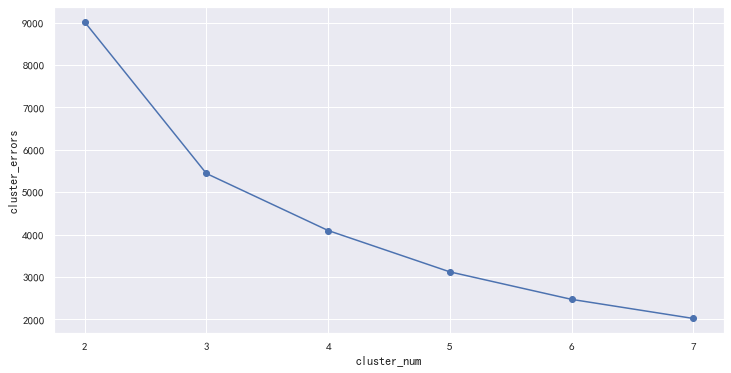

In [81]:
#可视化模型聚类数和模型误差平方和
error_df = pd.DataFrame({'cluster_num':list(range(2,8)),'cluster_errors':cluster_errors})
plt.figure(figsize=(12,6))
plt.plot(error_df['cluster_num'],error_df['cluster_errors'],marker='o')
plt.xlabel('cluster_num')
plt.ylabel('cluster_errors')
plt.show()

* 根据手肘法，K值应该选取3

In [123]:
k_means = KMeans(n_clusters=3,n_init=20,n_jobs=2,random_state=2)
#应用模型
predict_cluster = k_means.fit_predict(train_data)
k_means.cluster_centers_

array([[ 1.54086676, -0.34921133, -0.15788165],
       [-0.51221653,  0.05257211, -0.02196524],
       [-0.86583208,  8.07673458,  9.3260465 ]])

In [125]:
#将聚类结果合并到rfm_df
rfm_df['label'] = predict_cluster
#统计每一类的聚类结果
rfm_df['label'].value_counts()
#统计每一类群体均值
rfm_df.groupby('label').mean()

,Recency,Frequency,Monetary
label,,,
0,246.122355,1.581417,629.931399
1,40.821761,4.676999,1850.897530
2,5.461538,66.500000,85826.078077


In [201]:
# 客户群1 --> 0 ，客户群2 --> 1 ， 客户群3 --> 2
label_lst = ['客户群1','客户群2','客户群3']
label_customer_count_lst = [1087,3226,26]

In [206]:
pie_1 = (
        Pie(init_opts=opts.InitOpts(width='600px',height='350px',theme=ThemeType.SHINE))
        .add(
            "",
            [list(z) for z in zip(label_lst, label_customer_count_lst)],
            radius=["35%", "70%"],
        )
        .set_global_opts(
            title_opts=opts.TitleOpts(title="客户群数量分布"),
            legend_opts=opts.LegendOpts(
                orient="vertical", pos_top="15%", pos_left="2%"
            ),
            #显示工具箱，竖向,位置最右侧
            toolbox_opts=opts.ToolboxOpts(orient='vertical'),
        )
        .set_series_opts(label_opts=opts.LabelOpts(formatter="{c}"))
    )
pie_1.render_notebook()

In [168]:
from pyecharts.charts import Radar,Pie,Page

In [211]:
radar_1 = (
        Radar(init_opts=opts.InitOpts(width='600px',height='350px',theme=ThemeType.SHINE))
        .add_schema(
            schema=[
                opts.RadarIndicatorItem(name='Recency', max_=250),
                opts.RadarIndicatorItem(name="Frequency", max_=70),
                opts.RadarIndicatorItem(name="Monetary", max_=86000),
            ]
        )
        .add("客户群体1", [[246.122355,1.581417,629.931399]],color='red')
        .add("客户群体2", [[40.821761,4.676999,1850.897530]],color='yellow')
        .add("客户群体3", [[5.461538,66.500000,85826.078077]],color='blue')    
        .set_series_opts(label_opts=opts.LabelOpts(is_show=False))
        .set_global_opts(title_opts=opts.TitleOpts(title="客户群体特征分布"),
            #图例位置
            legend_opts=opts.LegendOpts(orient='vertical',pos_top='10%' ,pos_left='10%'),
            #显示工具箱，竖向,位置最右侧
            toolbox_opts=opts.ToolboxOpts(orient='vertical'),
            #设置滑动窗口起始和终止
#             datazoom_opts=opts.DataZoomOpts(range_start=0,range_end=100),
                        )
    )
radar_1.render_notebook()

* 客户群体1 --> 低价值客户 占比近30% - 提高留存、提高活跃度
    - R值很大，F、M值都很低，即低价值客户群体，最近一次购买记录间隔很久远，并且下单次数和消费金额都很低
* 客户群体2 --> 重点发展客户 占比近70% 客户基数大，可发展性强 - 提高活跃度
    - R值相比客户群体1有所降低、F值、M值相比客户群体1有所增加，即重要发展客户
    - 并且客户群体基数巨大，需要针对这部分客户展开相应营销活动，提高客户活跃度、刺激消费欲望
* 客户群体3 --> 高价值客户 占比不到1% - 重点维持，注重客户体验
    - R值很低，F、M值都很高，即高价值客户，重要保持客户，
    - 这部分客户最近一次购买记录离结算日很近，而且消费欲和消费能力都是极高的，这个占比不到整个群体1%的客户群体（26位）贡献了超25%的消费金额，要特别重点照顾这部分客户的购买体验，进一步提高客户忠诚度，持续维系这部分客户

In [212]:
#将所有可视化结果展示到一个HTML页面中
page_1 = Page(interval=0,layout=Page.SimplePageLayout,page_title='在线电商销售数据可视化')
page_1.add(bar_1, effectScatter_1, bar_2, line_2, line_3, pie_1, radar_1  )
page_1.render()